In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tqdm import tqdm
import json
import pickle
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler
from lightautoml.validation.np_iterators import TimeSeriesIterator


In [2]:
X = pickle.load(open("../data/preprocessed/features.pkl", "rb"))

In [3]:
sot = pd.read_csv("../data/raw/sotrudniki.csv", sep=";", parse_dates=["date"])

In [4]:
new_X = pd.merge(X, sot[['hash_tab_num', 'date', "sick"]], on=['hash_tab_num', 'date'], how="left")

In [5]:
X.shape, sot.shape, new_X.shape

((111287, 171), (99214, 23), (111287, 172))

In [6]:
def add_rolling_features(X, window=12):
    X = X.copy().drop("sick", axis=1)
    
    # fill nans
    cat_feats = X.select_dtypes(include=['category']).columns
    for col in cat_feats:
        try:
            X[col] = X[col].cat.add_categories("nan").fillna("nan")
        except:
            X[col] = X[col].fillna("nan")
        
    float_feats = X.select_dtypes(include=['float64', "int64"]).columns
    for col in float_feats:
        X[col] = X[col].fillna(X[col].mean()).fillna(-100)
    
    cols_for_merge = ["date", "hash_tab_num"]
    list_to_concat = []
    for idx in tqdm(X["hash_tab_num"].unique()):
        # date
        this_sot = X[X["hash_tab_num"]==idx].set_index("date")
#         this_sot["shifted_sick"] = this_sot["sick"].shift(-1).fillna(0)
        for col in cat_feats:
            this_sot[col] = this_sot[col].rank(method='dense')
        roll = this_sot.rolling(window, min_periods=1)
        
        real_mean = roll[float_feats].mean().rename(lambda x: f"float_mean_win{window}_{x}", axis=1)
        real_max = roll[float_feats].max().rename(lambda x: f"float_max_win{window}_{x}", axis=1)
        real_min = roll[float_feats].min().rename(lambda x: f"float_min_win{window}_{x}", axis=1)
        
        cat_count = roll[cat_feats].count().rename(lambda x: f"cat_cnt_win{window}_{x}", axis=1)
        cat_count_unique = roll[cat_feats].apply(lambda x: len(set(x))).fillna(0).rename(lambda x: f"cat_ucnt_win{window}_{x}", axis=1)
        
        
        res_df = pd.concat([
            this_sot[["hash_tab_num"]],
            real_mean, real_max, real_min,
            cat_count, cat_count_unique,
        ], axis=1)
        
#         res_df["sick_prev_count"] = roll["shifted_sick"].sum()
        
        list_to_concat.append(res_df.reset_index())
#     return list_to_concat
    return pd.concat(list_to_concat, axis=0, ignore_index=True)

In [ ]:
r = add_rolling_features(new_X)

 42%|████▏     | 1096/2619 [01:20<01:58, 12.84it/s]

In [36]:
r.shape

(111287, 496)

In [37]:
X_full = pd.merge(new_X, r, on=['hash_tab_num', 'date'], how="left")

In [38]:
X_train = X_full[~X_full["sick"].isna()]
X_test = X_full[X_full["sick"].isna()]

In [39]:
X_train.shape, X_test.shape

((90266, 666), (21021, 666))

In [40]:
def pandas_fill(arr):
    ser = pd.Series(arr)
    ser = ser.fillna(ser.mean())
    return ser.values

In [43]:
# # holdout split:
# X_ho = X_train[(X_train['date'] > '2018-08-01') & (X_train['date'] <= '2019-08-01')].copy()
# X_tr = X_train[~X_train.index.isin(X_ho.index)]

In [47]:
X_tr = X_train

In [44]:
X_train.shape, X_tr.shape, X_ho.shape

((90266, 666), (67572, 666), (22694, 666))

In [8]:

task = Task('binary', )

roles = {
    'target': 'sick',
    'category': X_tr.select_dtypes(include=['category']).columns.tolist(),
    DatetimeRole(seasonality=("y", "m"), date_format='%Y-%m-%d', base_feats=True): 
        X_tr.select_dtypes(include=['datetime64']).columns.tolist(),
}

cat_cols = X_tr.select_dtypes(include=['category']).columns
X_tr[cat_cols] = X_tr[cat_cols].astype(str)

N_THREADS = 30 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 15000 # Time in seconds for automl run



cv_iter = TimeSeriesIterator(X_tr["date"].astype(np.datetime64), n_splits=5, sorted_kfold=False)

automl = TabularAutoML(task = task, 
                   timeout = TIMEOUT,
                   cpu_limit = N_THREADS,
                   general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                   reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(X_tr, roles = roles, cv_iter=cv_iter)

#     models.append(model)

p, r, thresholds = precision_recall_curve(X_tr["sick"], pandas_fill(oof_pred.data[:, 0]))
f1_scores = 2 * r * p / (r + p)
f1_scores = f1_scores[p > 0]
th = thresholds[np.argmax(f1_scores)]
print("Results: ", th, max(f1_scores))

NameError: name 'X_tr' is not defined

In [46]:
# ho_pred = automl.predict(X_ho).data[:, 0]
# f1_score(X_ho["sick"], (ho_pred > th).astype('int'))

0.30391496369488735

In [49]:
sub_pred = automl.predict(X_test).data[:, 0]

In [50]:
sub = X_test[['hash_tab_num', 'date']].copy()
sub['target'] = (sub_pred > th).astype('int')
sub.to_csv('../data/submissions/sub_aml_windf_2.csv', index=False, sep=';')

CPU times: user 51.7 ms, sys: 115 µs, total: 51.8 ms
Wall time: 49.7 ms


<AxesSubplot:xlabel='Feature'>

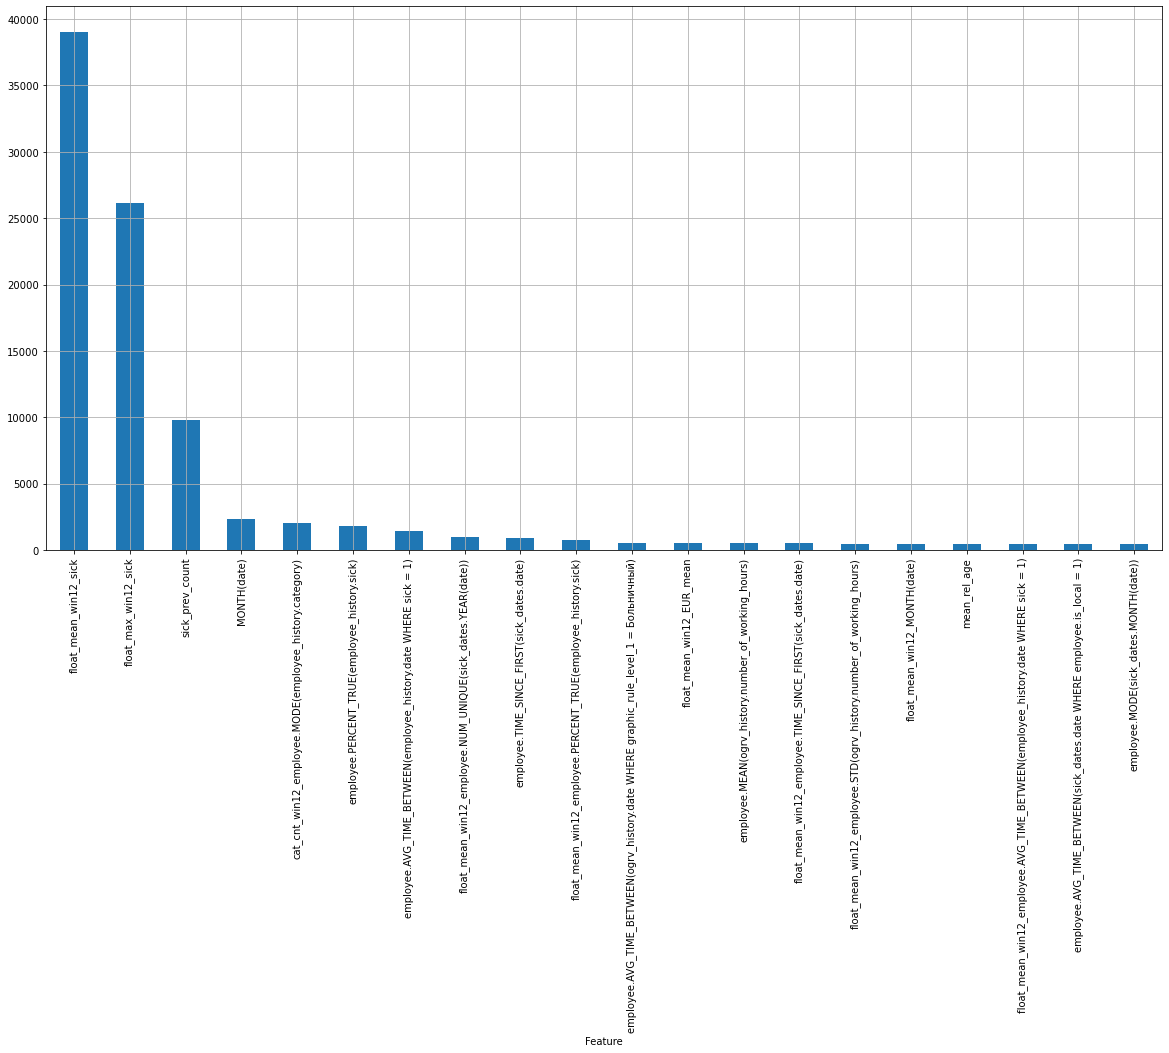

In [28]:

%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'][:20].plot.bar(figsize = (20, 10), grid = True)

In [27]:
fast_fi.set_index('Feature')['Importance']

Feature
float_mean_win12_sick                                                  39001.519429
float_max_win12_sick                                                   26162.291412
sick_prev_count                                                         9788.236088
MONTH(date)                                                             2312.785488
cat_cnt_win12_employee.MODE(employee_history.category)                  2033.748882
                                                                           ...     
float_max_win12_employee.NUM_UNIQUE(ogrv_history.MONTH(date))              0.000000
float_max_win12_employee.NUM_UNIQUE(ogrv_history.YEAR(date))               0.000000
float_min_win12_employee.MODE(employee_history.child_num)                  0.000000
float_max_win12_employee.NUM_UNIQUE(ogrv_history.work_shift_type)          0.000000
float_max_win12_employee.MEAN(sick_dates.TIME_SINCE_PREVIOUS(date))        0.000000
Name: Importance, Length: 663, dtype: float64